In [1]:
import os
import keras
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from keras.models import Model
import matplotlib.pyplot as plt
from keras import layers, models
from keras.utils import plot_model
from keras.models import load_model
from keras.models import Sequential
from skimage.transform import resize
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.optimizers import Adamax,Nadam,Adam,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization,Input, concatenate, AveragePooling2D,GlobalAveragePooling2D,ReLU, Add
warnings.filterwarnings('ignore')

2025-06-13 05:02:07.475494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749790927.674144      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749790927.734351      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras

# === Load data ===
train_data = np.load('/kaggle/input/ass6-dataset/train_data.npz')
X_loaded = train_data['X_train']
y_loaded = train_data['y_train']
test_data = np.load('/kaggle/input/ass6-dataset/test_data.npz')
test_images = test_data['X_test']
index = test_data['index']

# === Label Encoding ===
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_loaded)
num_classes = len(np.unique(y_encoded))

# === Train/Validation Split ===
X_train, X_val, y_train, y_val = train_test_split(
    X_loaded, y_encoded, test_size=0.2, random_state=42
)

# === Normalize (data already in [0, 1]) ===
# Just ensure float32
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
test_images = test_images.astype(np.float32)

# === One-hot encode labels ===
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)


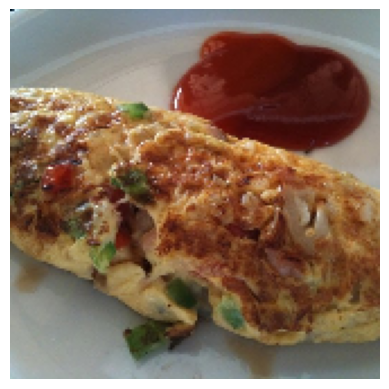

[6]


In [3]:
plt.imshow(X_train[0])  # Should work now
plt.axis('off')
plt.show()

print(label_encoder.inverse_transform([np.argmax(y_train[0])]))


In [4]:
print("Train Min:", X_train.min())
print("Train Max:", X_train.max())


Train Min: 0.0
Train Max: 1.0


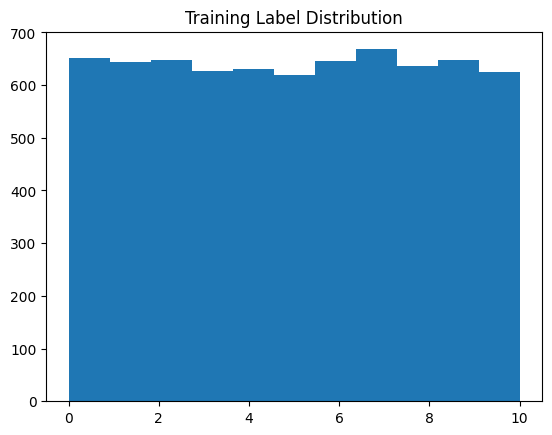

In [5]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist(np.argmax(y_train, axis=1), bins=11)
plt.title("Training Label Distribution")
plt.show()

In [6]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [15]:
from tensorflow.keras import layers, models, regularizers

def create_model(input_shape=(164, 164, 3), num_classes=11):
    l2 = regularizers.l2(0.00001)  # You can adjust 0.001 based on performance
    
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=l2)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)


In [16]:
loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

In [17]:
model = create_model()

In [18]:
# === Compile model ===
model.compile(
    optimizer='Adam',
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [19]:
import math
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau


# === Learning rate scheduler ===
def cosine_annealing(epoch, lr):
    total_epochs = 100
    lr_min = 0.00001
    lr_max = 0.0005
    return lr_min + (lr_max - lr_min) * (1 + math.cos(math.pi * epoch / total_epochs)) / 2

callbacks = [
    LearningRateScheduler(cosine_annealing),
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
]


In [20]:
# Fit the model
history = model.fit(X_train, y_train, batch_size=64,
          epochs=50,
          validation_data=(X_val, y_val),
          callbacks = callbacks)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - accuracy: 0.2306 - loss: 2.5086 - val_accuracy: 0.0875 - val_loss: 11.3639 - learning_rate: 5.0000e-04
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.3893 - loss: 1.8691 - val_accuracy: 0.1244 - val_loss: 4.7191 - learning_rate: 4.9988e-04
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.4246 - loss: 1.7338 - val_accuracy: 0.1165 - val_loss: 3.9254 - learning_rate: 4.9952e-04
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.5056 - loss: 1.4878 - val_accuracy: 0.2091 - val_loss: 3.5852 - learning_rate: 4.9891e-04
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.5817 - loss: 1.2578 - val_accuracy: 0.3784 - val_loss: 1.9942 - learning_rate: 4.9807e-04
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.6541 - loss: 1.0716 - val_accuracy: 0.4477 - val_loss: 1.7590 - learning_rate: 4.9698e-04
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/s

In [21]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    steps_per_epoch=len(X_train) // 64,
    epochs=50,  # train long
    validation_data=(X_val, y_val),
    callbacks = callbacks
)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 47s 353ms/step - accuracy: 0.3421 - loss: 2.7815 - val_accuracy: 0.3801 - val_loss: 2.7223 - learning_rate: 5.0000e-04
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 38s 342ms/step - accuracy: 0.4017 - loss: 1.9263 - val_accuracy: 0.4284 - val_loss: 1.8379 - learning_rate: 4.9988e-04
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 339ms/step - accuracy: 0.4487 - loss: 1.7118 - val_accuracy: 0.2801 - val_loss: 3.3929 - learning_rate: 4.9952e-04
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 38s 347ms/step - accuracy: 0.4940 - loss: 1.5732 - val_accuracy: 0.4074 - val_loss: 2.3167 - learning_rate: 4.9891e-04
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 38s 342ms/step - accuracy: 0.5187 - loss: 1.4577 - val_accuracy: 0.5017 - val_loss: 1.6774 - learning_rate: 4.9807e-04
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 340ms/step - accuracy: 0.5576 - loss: 1.3716 - val_accuracy: 0.5011 - val_loss: 1.6033 - learning_rate: 4.9698e-04
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 33

In [22]:
# === Evaluate ===
loss, acc = model.evaluate(X_val, y_val, verbose=2)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")

55/55 - 1s - 14ms/step - accuracy: 0.7403 - loss: 0.9561
Validation Loss: 0.9561
Validation Accuracy: 0.7403


In [23]:
# Predict the labels for the test images
predictions = model.predict(test_images)

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step


In [25]:
# Convert predictions from one-hot encoding to class labels
predicted_labels = np.argmax(predictions, axis=1)

In [26]:
# Create a DataFrame
df = pd.DataFrame({
    'id': index,
    'label': predicted_labels
})
# Save to CSV
df.to_csv('F2021376087-2.csv', index=False)